# Heart Failure Project (Group 9)

### Introduction:

"Cardiovascular diseases (CVDs) are the number 1 cause of death globally" (LARXEL, kaggle) and it is truly concerning how it is taking over many lives, like family members losing their love ones due to it, people needing to live their lives in hospitals, and so on. Our goal of this project is to identify factors contributing to heart failure and construct a predictive model to identify individuals in urgent need of medical attention. After conducting some research, we found that "[heart failure] is predominantly a disorder of aging, with prevalence rates increasing exponentially from less than 1% in the population under age 50 to about 10% in individuals over the age of 80" (Rich, The Journals of Gerontology: Series A) and "large meta-analysis that included community-based studies and trials observed lower mortality in HFpEF compared with HFrEF" (Bourlag and Colucci, UpToDate) where "HFrEF [means the heart's ejection fraction is] less than or equal to 40% [and] HFpEF [is when ejection fraction] is greater than or equal to 50%" (Hajouli and Ludhwani, National Library of Medicine).

### Research Question:

**To what extent do age and ejection fraction contribute to heart failure-related mortality? Are these factors interrelated, or are they independent of each other?**

We will conduct an analysis to find out.

### Dataset and Methodology:

Obtained from Kaggle, the dataset, released by LARXEL in 2020, encompasses various factors such as age, sex, ejection fraction, whether someone smokes, has diabetes, has high blood pressure, and so on. For this project, we chose to focus on age and ejection fraction given their potential correlation with mortality (as stated above). We plan to use knn classification, with age and ejection fraction as predictors and survival status as the classifier. The goal is to predict whether immediate medical attention is necessary. In case of a predicted death, urgent intervention is recommended, while predicted survival prompts precautionary measures to prevent death.

In [2]:
#run necessary libraries and install necessary packages
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [3]:
#read data directly from the web
data_from_link <- read_csv("https://raw.githubusercontent.com/KristenisHuaiyi/Data_Science_Project/main/data/heart_failure_clinical_records_dataset.csv.xls")
data_from_link

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0
50,0,196,0,45,0,395000,1.6,136,1,1,285,0


                                                Table 1.0 Raw Data

In [4]:
#find number of rows and columns of dataset
data_nrow <- nrow(data_from_link)
data_nrow

data_ncol <- ncol(data_from_link)
data_ncol

[1] 299

[1] 13

This dataset consists of 299 rows and 13 columns. The DEATH_EVENT variable has values 0 and 1 which means survived and died respectively (This was mentioned on Kaggle by the publisher of the dataset). We will now wrangle the data and select the variables that we are going to work with.

In [5]:
#wrangling the data by selecting the predictors we would work with and 
#converting the response variable (classifier) DEATH_EVENT to the factor datatype and renaming it to "survived"

data_wrangled <- data_from_link |> 
            select(age, ejection_fraction, DEATH_EVENT) |>
            mutate(DEATH_EVENT = as_factor(DEATH_EVENT)) |>
            mutate(DEATH_EVENT = fct_recode(DEATH_EVENT, "Yes" = "0", "No" = "1")) |>
            rename("survived" = "DEATH_EVENT") 

data_wrangled

age,ejection_fraction,survived
<dbl>,<dbl>,<fct>
75,20,No
55,38,No
65,20,No
⋮,⋮,⋮
45,60,Yes
45,38,Yes
50,45,Yes


    Table 1.1: Wrangled Data

### K-NN Classification:

As mentioned in the introduction, we will use the k-nn algorithm to perform classification on our predictors: age and ejection fraction to see if our observations lie under the category: "yes, they survived" or "no, they died." We would then produce a model to predict if a patient in the future is going to survive or die.

In [6]:
#set the random seed in R
set.seed(1)

#split the data into training set and testing set
heart_split <- initial_split(data_wrangled, prop = 0.75, strata = survived)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train
heart_test

age,ejection_fraction,survived
<dbl>,<dbl>,<fct>
75,20,No
55,38,No
90,40,No
⋮,⋮,⋮
62,38,Yes
55,38,Yes
45,60,Yes


age,ejection_fraction,survived
<dbl>,<dbl>,<fct>
65,20,No
50,20,No
65,20,No
⋮,⋮,⋮
60,35,Yes
45,38,Yes
50,45,Yes


    Table 1.2 & 1.3: Training Set
    and Testing Set Respectively

In [7]:
#show the number of observations in the training set and if there are any missing data
train_nrow <- nrow(heart_train)
any_missing_data <- sum(is.na(heart_train))
summarize(heart_train, train_nrow, any_missing_data)

train_nrow,any_missing_data
<int>,<int>
224,0


    Table 1.4: Summary of 
        Training Set

Our training data consists of 224 rows and doesn't have any missing data.

In [8]:
#summarize count of each classifier in the training set
survive_or_death_summarize <- heart_train |> 
                           group_by(survived) |>
                           summarize(count = n())
survive_or_death_summarize

survived,count
<fct>,<int>
Yes,152
No,72


    Table 1.5: Summary     
    of Classifiers in
       Training Set

Out of the 224 rows of training data, 152 are people who survived and 72 are people who died.

In [9]:
#summarize variables/predictors in the training set
summarize_age <- heart_train |>
                 summarize(variable = "age", 
                           min = min(age), 
                           max = max(age), 
                           mean = mean(age))
summarize_ejection_fraction <- heart_train |>
                               summarize(variable = "ejection_fraction", 
                                         min = min(ejection_fraction), 
                                         max = max(ejection_fraction),
                                         mean = mean(ejection_fraction))

train_summarized <- rbind(summarize_age, summarize_ejection_fraction)
train_summarized

variable,min,max,mean
<chr>,<dbl>,<dbl>,<dbl>
age,40,95,60.89881
ejection_fraction,14,80,37.75893


    Table 1.6: Summary of Predictors
            in Training Set

We summarized the predictors to see the min, max, and mean to know their range and average values.

### Visualization:

Now, using our training data, we will see if our predictors have a relationship with one another that indicates heart failure.

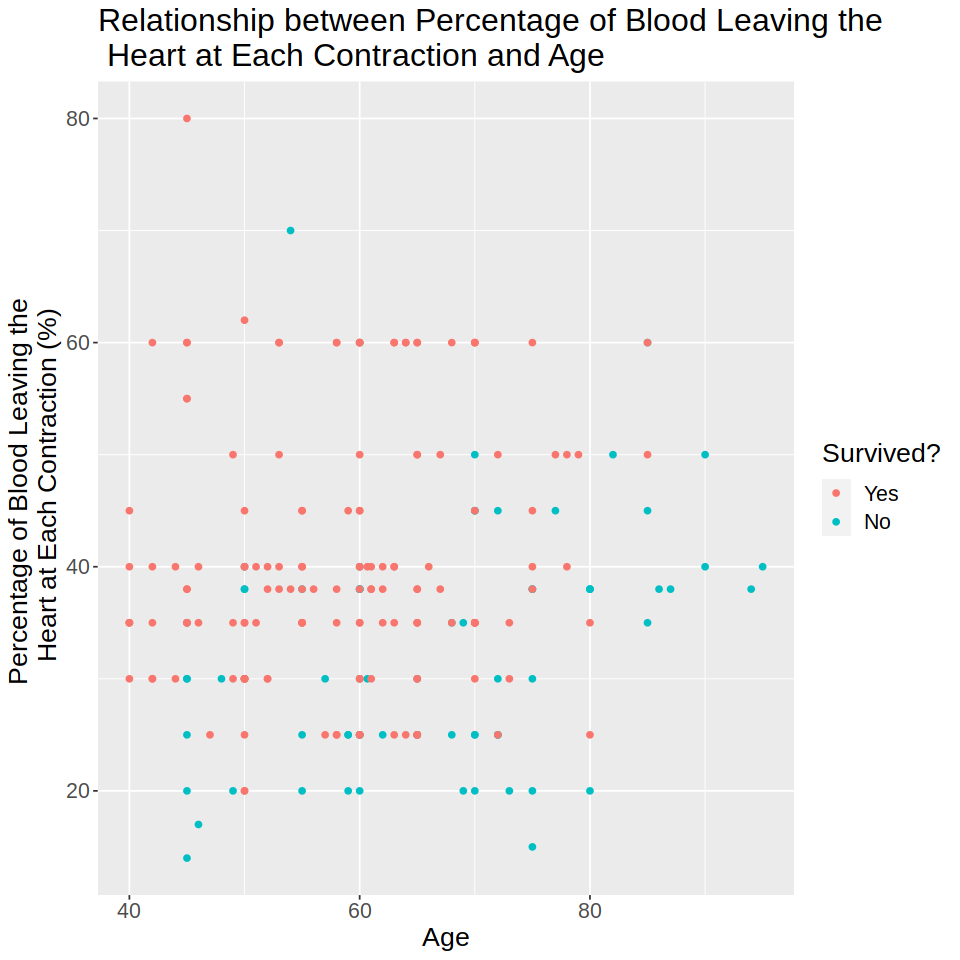

In [10]:
#set our graph to a proper size for visualization
options(repr.plot.width = 8, repr.plot.height = 8)

#visualize the data with a scatter plot
train_graph_point <- heart_train |>
            ggplot(aes(x = age, y = ejection_fraction, color = survived)) +
            geom_point() + 
            labs(x = "Age", 
                 y = "Percentage of Blood Leaving the \n Heart at Each Contraction (%)",
                 color = "Survived?") +
            ggtitle("Relationship between Percentage of Blood Leaving the \n Heart at Each Contraction and Age") +
            theme(text = element_text(size = 16))
train_graph_point

                Figure 1.0: Scatter Plot of Age versus Ejection Fraction
                        with "Survived?" as a Classifier

The plot above suggests a somewhat weak relationship, but it still indicates that there are more deaths when the ejection fraction is under 40%. This corresponds with our earlier research findings, highlighting a higher mortality rate for individuals with HFrEF (ejection fraction ≤ 40%). Moreover, there is an observable increase in deaths as age rises.

### K-NN Classification cont'd:

In [11]:
#make a recipe where "survived" is the response while age and ejection_fraction are predictors
#scale and center the predictors
heart_recipe <- recipe(survived ~ age + ejection_fraction, data = heart_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [12]:
#apply cross-validation to find the best K 
#split the training data into 5 validation set.

set.seed(2)
heart_vfold <- vfold_cv(heart_train, v = 5, strata = survived)

knn_tune <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_results <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(knn_tune) |>
                tune_grid(resamples = heart_vfold, grid = 5) |>
                collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.7225296,5,0.03213423,Preprocessor1_Model1
3,roc_auc,binary,0.7644700,5,0.03070227,Preprocessor1_Model1
4,accuracy,binary,0.7138340,5,0.02910343,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.7778955,5,0.04000460,Preprocessor1_Model4
13,accuracy,binary,0.7626482,5,0.03121091,Preprocessor1_Model5
13,roc_auc,binary,0.7718356,5,0.03461621,Preprocessor1_Model5


                Table 1.7: Results from Cross Validation

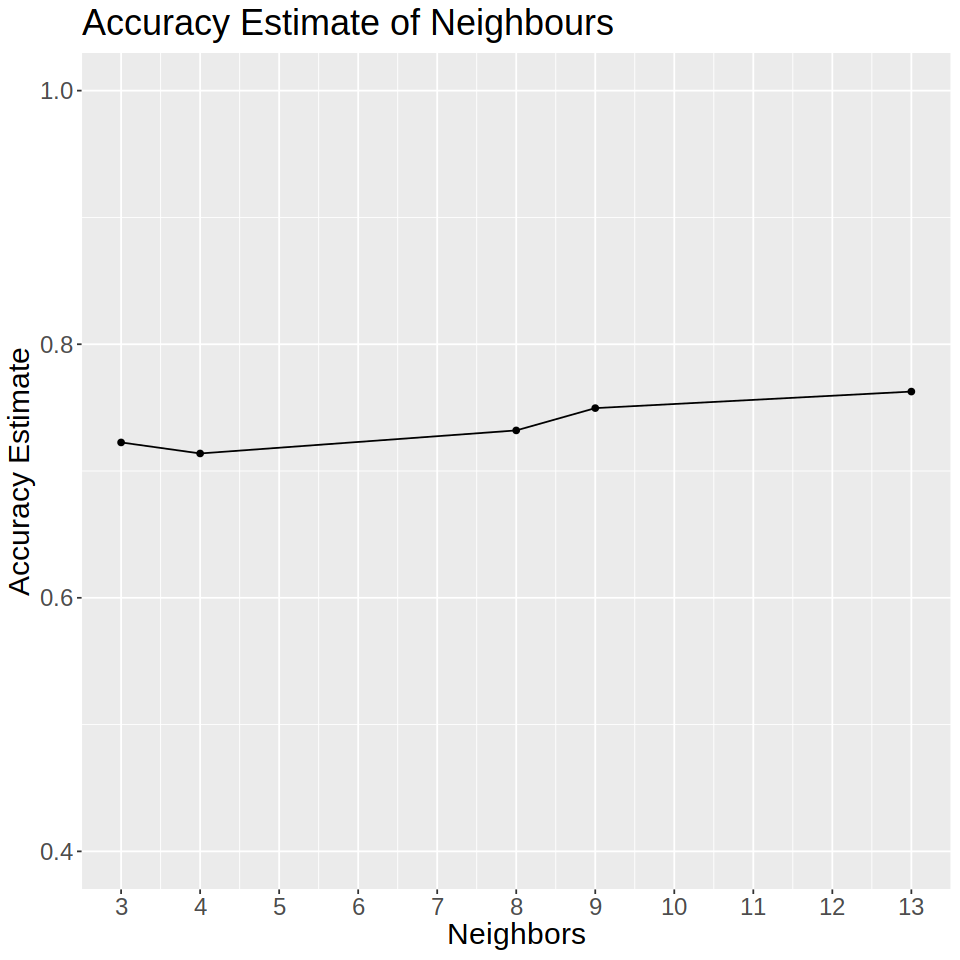

In [13]:
accuracies <- knn_results |>
            filter(.metric == "accuracy")

#set our graph to a proper size for visualization
options(repr.plot.width = 8, repr.plot.height = 8)

#visualize the neighbors versus accuracy estimate scatter plot to find the optimal k value
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Accuracy Estimate of Neighbours") +
                    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
                    scale_y_continuous(limits = c(0.4, 1.0)) +
                    theme(text = element_text(size = 18))
accuracy_versus_k

                        Figure 1.1: Accuracy Estimate of Different K-values

In [14]:
#From the scatterplot, we could see that k = 9 would give us the best accuracy estimate
#Note that since 13 is one of the endpoints and it does not differ too much from the next highest accuracy estimate (when k=9), we chose to not use it
#So we can now build our final model

#specification
heart_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

#creating a workflow
heart_final_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_final_spec) |>
  fit(heart_train)

In [15]:
#Use the final model to make "predictions" on our testing data
heart_failure_predictions <- predict(heart_final_fit, heart_test) |>
        bind_cols(heart_test)

#Report the accuracy of our model
heart_metrics <- heart_failure_predictions |>
        metrics(truth = survived, estimate = .pred_class)

#Report the confusion matrix
heart_conf_mat <- heart_failure_predictions |>
        conf_mat(truth = survived, estimate = .pred_class)

heart_metrics
heart_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7466667
kap,binary,0.3537415


          Truth
Prediction Yes No
       Yes  46 14
       No    5 10

    Table 1.8 & 1.9: Accuracy
     and Confusion Matrix of 
            Our Model

As the accuracy report shows, our model correctly predicted about 74.7% of our testing data. Although this percentage seems a little low, our model is not all that bad considering professionals that had been in the field for years or even decades could not predict heart failure and if someone would die from it to a high degree. So, this is very much expected.

### Summary:

Our model achieved 74.7% accuracy, indicating that age and ejection fraction are contributors to heart failure. While our aim was to utilize KNN classification to assist healthcare providers in identifying at-risk patients, the 74.7% accuracy suggests the need for more advanced models. Our current model does not suffice for real-life applications, so no, our findings were not too impactful. However, as first-year data science students, our model served its purpose reasonably well. We acknowledge the potential for professionals with more data and advanced statistical knowledge to create more robust models and we wish them luck, as our common goal is to minimize the mortality rate of patients. 

After exploring the dataset's 12 factors, we recognized the likelihood of numerous underlying contributors to heart failure beyond our exploration. We wonder what they could be. We also ponder the impact of those additional factors on predictive accuracy and model improvement. Even though we are just starting in the world of data science, we are excited to learn more and we are eager to see how healthcare predictions will keep getting better over time. 

### References: 

Borlaug, Barry A. Treatment and Prognosis of Heart Failure with Preserved Ejection Fraction, Wolters Kluwer, 28 Sept. 2023, www.uptodate.com/contents/treatment-and-prognosis-of-heart-failure-with-preserved-ejection-fraction/.

Hajouli, Said, and Dipesh Ludhwani. “Heart Failure and Ejection Fraction.” Heart Failure and Ejection Fraction - StatPearls-NCBI, National Library of Medicine, 23 Dec. 2022, www.ncbi.nlm.nih.gov/books/NBK553115/. 

Larxel. Heart Failure Prediction, Kaggle, 20 June 2020, www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data?select=heart_failure_clinical_records_dataset.csv. 

Rich, Michael W. “Heart Failure in the 21st Century: A Cardiogeriatric Syndrome.” Academic.Oup.Com, Gerontological Society of America, 1 Feb. 2001, www.academic.oup.com/biomedgerontology/article/56/2/M88/563356?login=false. 